# 데이터 불러오기 및 라벨링

### step1: 질병이 있음/없음만 구분

In [1]:
import os

# 데이터셋의 루트 디렉토리
dataset_directory = '/home/jeonk636/ear_classification/eardrumDs'

# 클래스 이름 및 라벨을 매핑하기 위한 딕셔너리 생성
# normal:0, abnormal: 1
label_map = {
    'Aom': 1,
    'Chornic': 1,
    'Earwax': 1,
    'Normal': 0,
    'OtitExterna': 1,
    'tympanoskleros': 1
}

# 이미지 파일 경로 및 라벨을 저장할 리스트
image_paths = []
image_labels = []

# 제외 폴더
exclude_folders = {'Earventulation', 'Foreign', 'PseduoMembran'}

# 각 폴더에 대해 이미지 파일 경로 및 해당 라벨을 리스트에 추가
for label_folder in os.listdir(dataset_directory):
    if label_folder in exclude_folders:  # 이 폴더는 건너뛴다.
        continue
    folder_path = os.path.join(dataset_directory, label_folder)
    
    for image_filename in os.listdir(folder_path):
        # 폴더 내 파일이 실제 파일인지 확인하고 '.ipynb_checkpoints' 폴더를 건너뛴다.
        full_path = os.path.join(folder_path, image_filename)
        if os.path.isfile(full_path) and '.ipynb_checkpoints' not in full_path:
            image_paths.append(full_path)
            image_labels.append(label_map[label_folder])


In [2]:
image_paths[0:5]

['/home/jeonk636/ear_classification/eardrumDs/Aom/aom_1.tiff',
 '/home/jeonk636/ear_classification/eardrumDs/Aom/aom_10.tiff',
 '/home/jeonk636/ear_classification/eardrumDs/Aom/aom_100.tiff',
 '/home/jeonk636/ear_classification/eardrumDs/Aom/aom_101.tiff',
 '/home/jeonk636/ear_classification/eardrumDs/Aom/aom_102.tiff']

In [3]:
print(image_labels[0:50])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [4]:
# 라벨 0과 라벨 1의 개수를 계산.
label_0_count = image_labels.count(0)
label_1_count = image_labels.count(1)

(label_0_count, label_1_count)

(534, 391)

Aom_cnt = 119  
Chornic_cnt = 62  
Earwax_cnt = 140  
Normal_cnt = 534  
OtitExterna_cnt = 41  
tympanoskleros_cnt = 28  

# Split the Dataset 6 : 2 : 2 

In [5]:
import numpy as np
from sklearn.model_selection import train_test_split

# 이미지 경로와 라벨을 Numpy 배열로 변환
image_paths = np.array(image_paths)
image_labels = np.array(image_labels)

# 전체 데이터를 훈련+검증 세트와 테스트 세트로 분할
x_train_all, x_test, y_train_all, y_test = train_test_split(
    image_paths, image_labels, stratify=image_labels, test_size=0.2, random_state=42)

# 훈련+검증 세트를 훈련 세트와 검증 세트로 분할
x_train, x_val, y_train, y_val = train_test_split(
    x_train_all, y_train_all, stratify=y_train_all, test_size=0.2, random_state=42)

In [6]:
# 결과 출력
print("Train set:", len(x_train))
print("Validation set:", len(x_val))
print("Test set:", len(x_test))

Train set: 592
Validation set: 148
Test set: 185


In [7]:
print("Normal in Train set:", np.count_nonzero(y_train == 0))
print("Abnormal in Train set:", np.count_nonzero(y_train == 1))

Normal in Train set: 342
Abnormal in Train set: 250


In [8]:
print("image_paths shape:",image_paths.shape)
print("image_labels shape:",image_labels.shape)

image_paths shape: (925,)
image_labels shape: (925,)


# train dataset을 Augmentation

### 목표: 정상 이미지 1000장, 비정상 이미지 1000장

#### A. 여러 종류의 증강함수를 만들기   
##### (GAN, Diffusion, Few-shot learning은 나중에 적용)

### 1. Spatial-Level Transforms

In [9]:
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import random

2024-05-02 05:59:11.665865: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-02 05:59:11.705816: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-02 05:59:11.705837: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-02 05:59:11.707111: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-02 05:59:11.714357: I tensorflow/core/platform/cpu_feature_guar

In [10]:
def flip_H(image):
    flipped_H = tf.image.flip_left_right(image)
    return flipped_H

def flip_V(image):
    flipped_V = tf.image.flip_up_down(image)
    return flipped_V

def rotate(image):
    #90, 180, 270도 랜덤 회전
    #나중에 각도를 더 다양하게 적용할지 말지 고민해보기 
    k = random.randint(1, 3)
    rotated = tf.image.rot90(image, k)
    return rotated

def crop(image):
    cropped = tf.image.central_crop(image, central_fraction=0.5)
    return cropped

In [11]:
# 이미지 파일을 로드하고 텐서로 변환하는 함수
# def load_and_preprocess_image(path):
#     image = Image.open(path)
#     image = image.convert('RGB')  # PIL 이미지를 RGB로 변환 (필요한 경우)
#     image = np.array(image)       # NumPy 배열로 변환
#     image = tf.image.convert_image_dtype(image, tf.float32)  # TensorFlow 텐서로 변환
#     return image

def load_and_preprocess_image(path, target_size=(500, 500)):
    # 이미지를 RGB로 변환하여 로드
    image = Image.open(path).convert('RGB')
    image = image.resize(target_size)  # 목표 크기로 리사이징
    image = np.array(image)  # 이미지를 numpy 배열로 변환
    image = tf.convert_to_tensor(image, dtype=tf.float32) / 255.0  # 텐서로 변환하고 정규화
    return image
    
# 이미지 경로로부터 이미지를 로드
ex_path = x_train_all[34]  # 예시 이미지 경로
image = load_and_preprocess_image(ex_path)

Spatial_aug = {
    'flip_H': flip_H(image),
    'flip_V': flip_V(image),
    'rotate': rotate(image),
    'crop': crop(image)
}

# 이미지를 시각화하기 위한 함수
def visualize_Spatial(image, Spatial_aug):
    fig, axes = plt.subplots(1, len(Spatial_aug) + 1, figsize=(20, 10))
    axes[0].imshow(image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    for i, (augmentation_name, augmented_image) in enumerate(Spatial_aug.items(), 1):
        axes[i].imshow(augmented_image)
        axes[i].set_title(augmentation_name)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

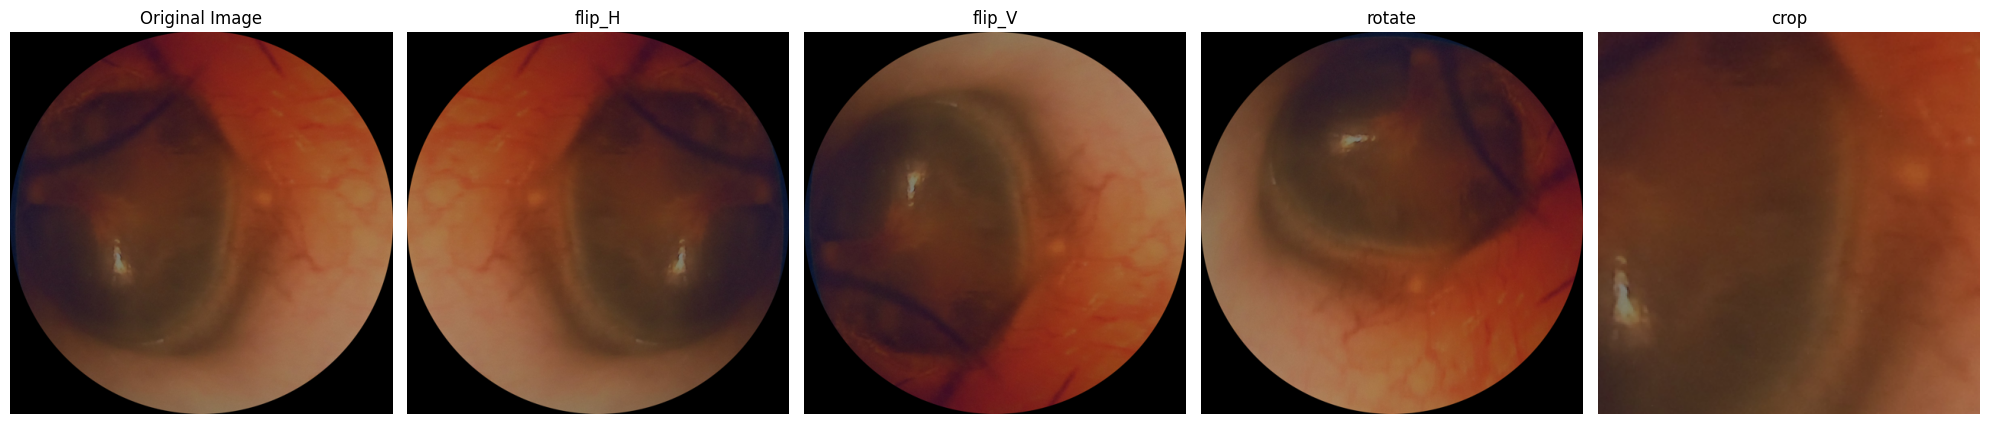

In [12]:
visualize_Spatial(image, Spatial_aug)

### 2.Pixel-Level Transforms

In [13]:
def CLAHE(image):
    # TensorFlow 텐서를 NumPy 배열로 변환하고 0-255 범위의 값으로 조정
    image = (image.numpy() * 255).astype(np.uint8)
    # RGB 채널을 BGR로 변경
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    # 각 채널에 CLAHE 적용
    channels = cv2.split(image)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahed_channels = [clahe.apply(c) for c in channels]
    clahed_image = cv2.merge(clahed_channels)
    # 다시 RGB 채널로 변경
    clahed_image = cv2.cvtColor(clahed_image, cv2.COLOR_BGR2RGB)
    # 이미지를 [0, 1] 범위로 정규화
    clahed_image = clahed_image / 255.0
    return clahed_image
    
def Hue(image):
    # HueSaturationValue
    hue_img = tf.image.adjust_hue(image, delta=0.1)
    hue_img = tf.image.adjust_saturation(hue_img, saturation_factor=1)
    return hue_img

def RandomContrast(image):
    # 이미지에 RandomContrast를 적용하고 결과를 [0, 1] 범위로 클리핑
    contrast_image = tf.image.random_contrast(image, lower=1.0, upper=3.0)
    contrast_image = tf.clip_by_value(contrast_image, 0.0, 1.0)  # 클리핑
    return contrast_image

def RandomGamma(image):
    # RandomGamma
    gamma_img = tf.image.adjust_gamma(image, gamma=0.5)
    return gamma_img

def RandomBrightness(image):
    # 이미지에 RandomBrightness를 적용하고 결과를 [0, 1] 범위로 클리핑
    bright_image = tf.image.random_brightness(image, max_delta=0.3)
    bright_image = tf.clip_by_value(bright_image, 0.0, 1.0)  # 클리핑
    return bright_image

def Blur(image):
    # TensorFlow 텐서를 NumPy 배열로 변환
    image = image.numpy()
    blur_img = cv2.blur(image, (5, 5))
    return blur_img

def gray(image):
    # ToGray
    togray_img = tf.image.rgb_to_grayscale(image)
    return togray_img

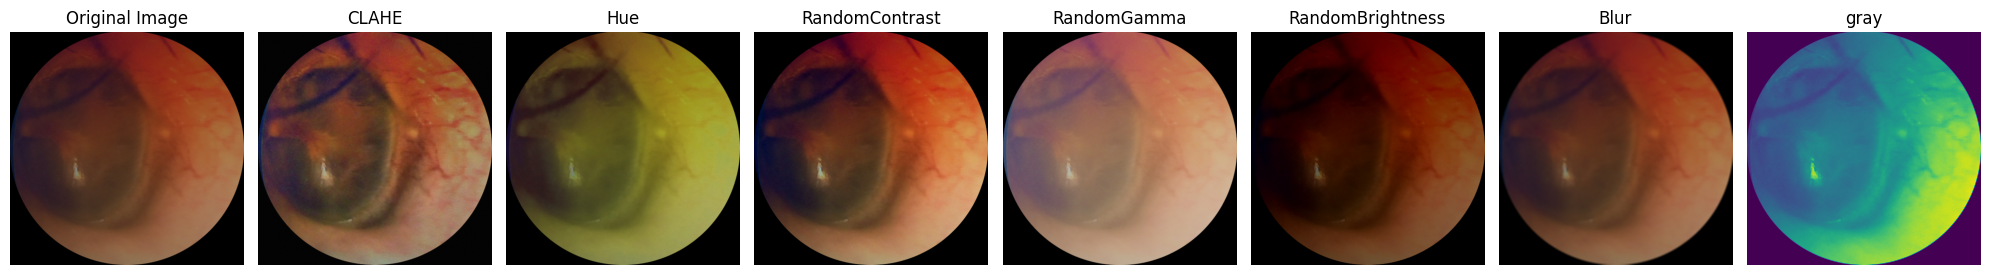

In [14]:
# 시각화를 위한 함수
def visualize_augmentations(image, augmentations):
    fig, axes = plt.subplots(1, len(augmentations) + 1, figsize=(20, 10))
    axes[0].imshow(image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    for i, (augmentation_name, augmented_image) in enumerate(augmentations.items(), 1):
        axes[i].imshow(augmented_image)
        axes[i].set_title(augmentation_name)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# 각 증강 기법을 적용.
augmentations = {
    'CLAHE': CLAHE(image),
    'Hue': Hue(image),
    'RandomContrast': RandomContrast(image),
    'RandomGamma': RandomGamma(image),
    'RandomBrightness': RandomBrightness(image),
    'Blur': Blur(image),
    'gray': gray(image)
}

# 시각화 실행
visualize_augmentations(image, augmentations)

In [15]:
import random

normal_indices = [i for i, label in enumerate(y_train) if label == 0] #정상이미지와 라벨 불러오기
abnormal_indices = [j for j, label in enumerate(y_train) if label == 1] #비정상이미지와 라벨 불러오기

#selected_normal = random.sample(normal_indices, 10) #그 중 n장을 랜덤으로 선택
#selected_abnormal = random.sample(abnormal_indices, 10)

selected_normal = normal_indices
selected_abnormal = abnormal_indices

selected_normal_images = [(x_train[i]) for i in selected_normal] #랜덤으로 선택된 정상이미지 경로
selected_normal_indexs = [(y_train[i]) for i in selected_normal] #랜덤으로 선택된 정상이미지 라벨
selected_abnormal_images = [(x_train[j]) for j in selected_abnormal]
selected_abnormal_indexs = [(y_train[j]) for j in selected_abnormal]

print("선택된 정상 고막 이미지 경로 및 라벨:")
print(selected_normal_images[:5])
print(selected_normal_indexs[:5])
print(len(selected_normal_images), len(selected_normal_indexs))
#for img_path in selected_normal_images:
    #print(f"경로: {img_path}")
#for label in selected_normal_indexs:
    #print(f"라벨: {label}")'''

print("선택된 비정상 고막 이미지 경로 및 라벨:")
print(selected_abnormal_images[:5])
print(selected_abnormal_indexs[:5])
print(len(selected_abnormal_images), len(selected_abnormal_indexs))

선택된 정상 고막 이미지 경로 및 라벨:
['/home/jeonk636/ear_classification/eardrumDs/Normal/normal_405.tiff', '/home/jeonk636/ear_classification/eardrumDs/Normal/normal_514.tiff', '/home/jeonk636/ear_classification/eardrumDs/Normal/normal_407.tiff', '/home/jeonk636/ear_classification/eardrumDs/Normal/normal_451.tiff', '/home/jeonk636/ear_classification/eardrumDs/Normal/normal_486.tiff']
[0, 0, 0, 0, 0]
342 342
선택된 비정상 고막 이미지 경로 및 라벨:
['/home/jeonk636/ear_classification/eardrumDs/Aom/aom_35.tiff', '/home/jeonk636/ear_classification/eardrumDs/Earwax/buson_124.tiff', '/home/jeonk636/ear_classification/eardrumDs/OtitExterna/otitexterna_12.tiff', '/home/jeonk636/ear_classification/eardrumDs/tympanoskleros/yamavekalker_3.tiff', '/home/jeonk636/ear_classification/eardrumDs/Earwax/buson_28.tiff']
[1, 1, 1, 1, 1]
250 250


## 증강함수 적용

In [16]:
aug_func_spatial = {
    'flip_H': flip_H,
    'flip_V': flip_V,
    'rotate': rotate,
    'crop': crop
}

aug_ratio_spatial = {
    'flip_H': 0.25,
    'flip_V': 0.25,
    'rotate': 0.25,
    'crop': 0.25
}

aug_func_pixel = {
    'CLAHE': CLAHE,
    'Hue': Hue,
    'RandomContrast': RandomContrast,
    'RandomGamma': RandomGamma,
    'RandomBrightness': RandomBrightness,
    'Blur': Blur
    #'gray': gray
}

aug_ratio_pixel = {
    'CLAHE': 0.1,
    'Hue': 0.1,
    'RandomContrast': 0.2,
    'RandomGamma': 0.1,
    'RandomBrightness': 0.3,
    'Blur': 0.2
    #'gray': 0.1
}

def apply_aug_spatial(images, augmentations, ratios):
    augmented_images = []
    func_names = list(augmentations.keys())  # 사전의 키를 리스트로 변환
    probabilities = [ratios[name] for name in func_names]  # 확률 추출
    aug_choice = np.random.choice(func_names, p=probabilities)  # 확률에 따라 선택
    augmented_image = aug_func_spatial[aug_choice](images)  # 증강 함수 적용
    augmented_images.append(augmented_image)
    return augmented_images

def apply_aug_pixel(images, augmentations, ratios):
    augmented_images = []
    func_names = list(augmentations.keys()) 
    probabilities = [ratios[name] for name in func_names]
    aug_choice = np.random.choice(func_names, p=probabilities) 
    augmented_image = aug_func_pixel[aug_choice](images)
    augmented_images.append(augmented_image)
    return augmented_images

#command+/
# aug_normal = []
# for image in selected_normal_images:
#     tensor = load_and_preprocess_image(image)  # RGB를 array로 변환
#     aug_normal.extend(apply_aug_spatial(tensor, aug_func_spatial, aug_ratio_spatial))

# aug_abnormal = []
# for image in selected_abnormal_images:
#     tensor = load_and_preprocess_image(image)
#     aug_abnormal.extend(apply_aug_pixel(tensor, aug_func_pixel, aug_ratio_pixel))

### Normal 이미지에 적용

In [17]:
random_select_normal = random.sample(selected_normal_images, 329)

aug_normal = []
for image in random_select_normal:
    tensor = load_and_preprocess_image(image)  # RGB를 array로 변환
    aug_normal.extend(apply_aug_spatial(tensor, aug_func_spatial, aug_ratio_spatial))
    aug_normal.extend(apply_aug_pixel(tensor, aug_func_pixel, aug_ratio_pixel))

In [18]:
print(len(aug_normal))

658


In [19]:
aug_normal_label = [0]*658
print(len(aug_normal_label))

658


### Abnormal 이미지에 적용

In [20]:
random_select_abnormal = random.choices(selected_abnormal_images, k=375)

aug_abnormal = []
for image in random_select_abnormal:
    tensor = load_and_preprocess_image(image)
    aug_abnormal.extend(apply_aug_spatial(tensor, aug_func_spatial, aug_ratio_spatial))
    aug_abnormal.extend(apply_aug_pixel(tensor, aug_func_pixel, aug_ratio_pixel))

In [22]:
print(len(aug_abnormal))

750


In [23]:
aug_abnormal_label = [1]*750
print(len(aug_abnormal_label))

750


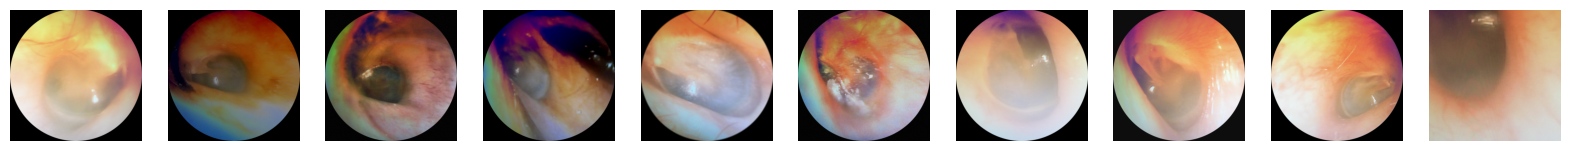

In [24]:
def plot_images(images):
    plt.figure(figsize=(20, 4))
    for i, image in enumerate(images[:10]):
        plt.subplot(1, 10, i + 1)
        plt.imshow(image)
        plt.axis('off')
    plt.show()

im = random.sample(aug_normal, 10)
# 시각화 실행
plot_images(im)

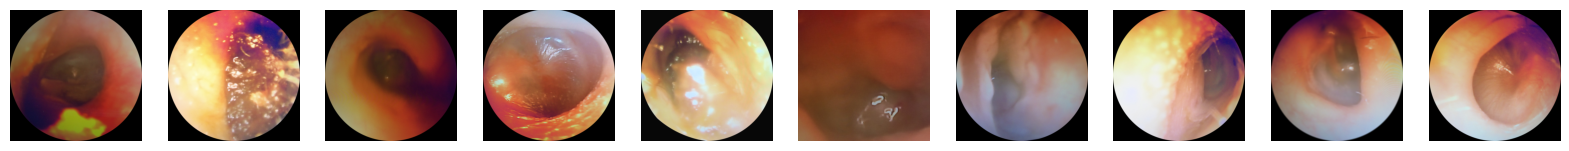

In [25]:
# 시각화 실행
im_ab = random.sample(aug_abnormal, 10)
plot_images(im_ab)

# 증강함수를 적용한 후 CNN

In [26]:
x_train = [load_and_preprocess_image(path) for path in x_train]
x_val = [load_and_preprocess_image(path) for path in x_val]
x_test = [load_and_preprocess_image(path) for path in x_test]

In [27]:
# NumPy 배열로 변환 (필요한 경우)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

aug_normal_label = np.array(aug_normal_label)
aug_abnormal_label = np.array(aug_abnormal_label)

def resize_image(image, target_size=(500, 500)):
    return tf.image.resize(image, target_size)
    
# def ensure_rgb(image):
#     if image.shape[-1] == 1:  # 이미지가 그레이스케일이라면
#         image = tf.image.grayscale_to_rgb(image)  # RGB로 변환
#     return image

aug_normal_resized = [resize_image(img) for img in aug_normal]
aug_abnormal_resized = [resize_image(img) for img in aug_abnormal]

x_train_resized = [resize_image(img) for img in x_train]

# aug_normal_resized2 = [ensure_rgb(img) for img in aug_normal_resized]
# aug_abnormal_resized2 = [ensure_rgb(img) for img in aug_abnormal_resized]

new_y_train = np.concatenate([y_train, aug_normal_label, aug_abnormal_label])

new_x_train = x_train_resized + aug_normal_resized + aug_abnormal_resized

print(len(new_x_train))  # x_train과 증강된 데이터의 총 길이를 출력
print(len(new_y_train))  # y_train과 증강된 라벨의 총 길이를 출력

2000
2000


In [28]:
new_x_train = tf.stack(new_x_train) 

In [29]:
x_val = tf.stack(x_val)

In [30]:
x_test = tf.stack(x_test)

In [37]:
# x_val_resized = [resize_image(img) for img in x_val]
# x_test_resized = [resize_image(img) for img in x_test]

# y_val = np.array(y_val)
# y_test = np.array(y_test)

# print(len(x_val_resized), len(y_val))
# print(len(x_test_resized), len(y_test))

In [38]:
# #new_x_train[1500]
# print(len(y_test))
# print(len(x_test))

In [ ]:
for img in new_y_train:
    print(img.shape, img.dtype)

In [ ]:
for img in y_val:
    print(img.shape, img.dtype)

In [ ]:
for img in x_test:
    print(img.shape, img.dtype)

In [31]:
print("new_x_train 길이:", len(new_x_train))
print("new_y_train 길이:", len(new_y_train))
print("x_val 길이:", len(x_val))
print("y_val 길이:", len(y_val))
print("x_test 길이:", len(x_test))
print("y_test 길이:", len(y_test))

new_x_train 길이: 2000
new_y_train 길이: 2000
x_val 길이: 148
y_val 길이: 148
x_test 길이: 185
y_test 길이: 185


In [32]:
# 첫 번째 항목의 형태와 데이터 타입을 출력
print("new_x_train 첫 번째 항목의 형태:", new_x_train[0].shape)
print("new_x_train 첫 번째 항목의 데이터 타입:", new_x_train[0].dtype)

print("x_val 첫 번째 항목의 형태:", x_val[0].shape)
print("x_val 첫 번째 항목의 데이터 타입:", x_val[0].dtype)

print("x_test 첫 번째 항목의 형태:", x_test[0].shape)
print("x_test 첫 번째 항목의 데이터 타입:", x_test[0].dtype)

new_x_train 첫 번째 항목의 형태: (500, 500, 3)
new_x_train 첫 번째 항목의 데이터 타입: <dtype: 'float32'>
x_val 첫 번째 항목의 형태: (500, 500, 3)
x_val 첫 번째 항목의 데이터 타입: <dtype: 'float32'>
x_test 첫 번째 항목의 형태: (500, 500, 3)
x_test 첫 번째 항목의 데이터 타입: <dtype: 'float32'>


In [38]:
# Define the model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(500, 500, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(2)
])

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train the model
history = model.fit(new_x_train, new_y_train, epochs=30, validation_data=(x_val, y_val))

# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test accuracy:', test_acc)

Epoch 1/30
63/63 [==============================] - 32s 485ms/step - loss: 2.7438 - accuracy: 0.5800 - val_loss: 0.5955 - val_accuracy: 0.6892
Epoch 2/30
63/63 [==============================] - 28s 448ms/step - loss: 0.6051 - accuracy: 0.6710 - val_loss: 0.5779 - val_accuracy: 0.6892
Epoch 3/30
63/63 [==============================] - 28s 451ms/step - loss: 0.5677 - accuracy: 0.6960 - val_loss: 0.6030 - val_accuracy: 0.6689
Epoch 4/30
63/63 [==============================] - 29s 458ms/step - loss: 0.5802 - accuracy: 0.6930 - val_loss: 0.5684 - val_accuracy: 0.7095
Epoch 5/30
63/63 [==============================] - 28s 444ms/step - loss: 0.5329 - accuracy: 0.7370 - val_loss: 0.5545 - val_accuracy: 0.7230
Epoch 6/30
63/63 [==============================] - 27s 435ms/step - loss: 0.5041 - accuracy: 0.7525 - val_loss: 0.5733 - val_accuracy: 0.7297
Epoch 7/30
63/63 [==============================] - 28s 440ms/step - loss: 0.5052 - accuracy: 0.7545 - val_loss: 0.5550 - val_accuracy: 0.7297

In [39]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 498, 498, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 249, 249, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 247, 247, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 123, 123, 64)      0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 968256)            0         
                                                                 
 dense_2 (Dense)             (None, 64)               

5/5 - 1s - loss: 2.0630 - accuracy: 0.6824 - 686ms/epoch - 137ms/step


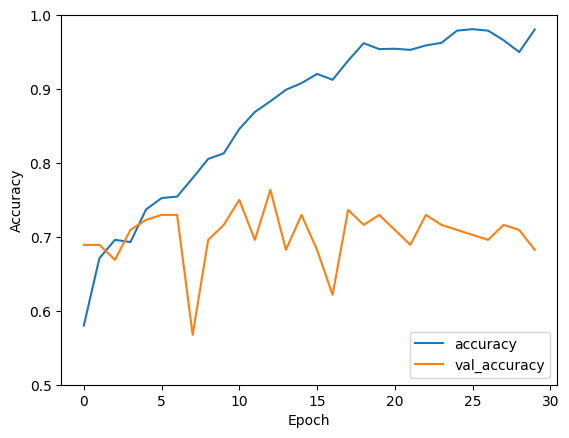

In [40]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(x_val,  y_val, verbose=2)

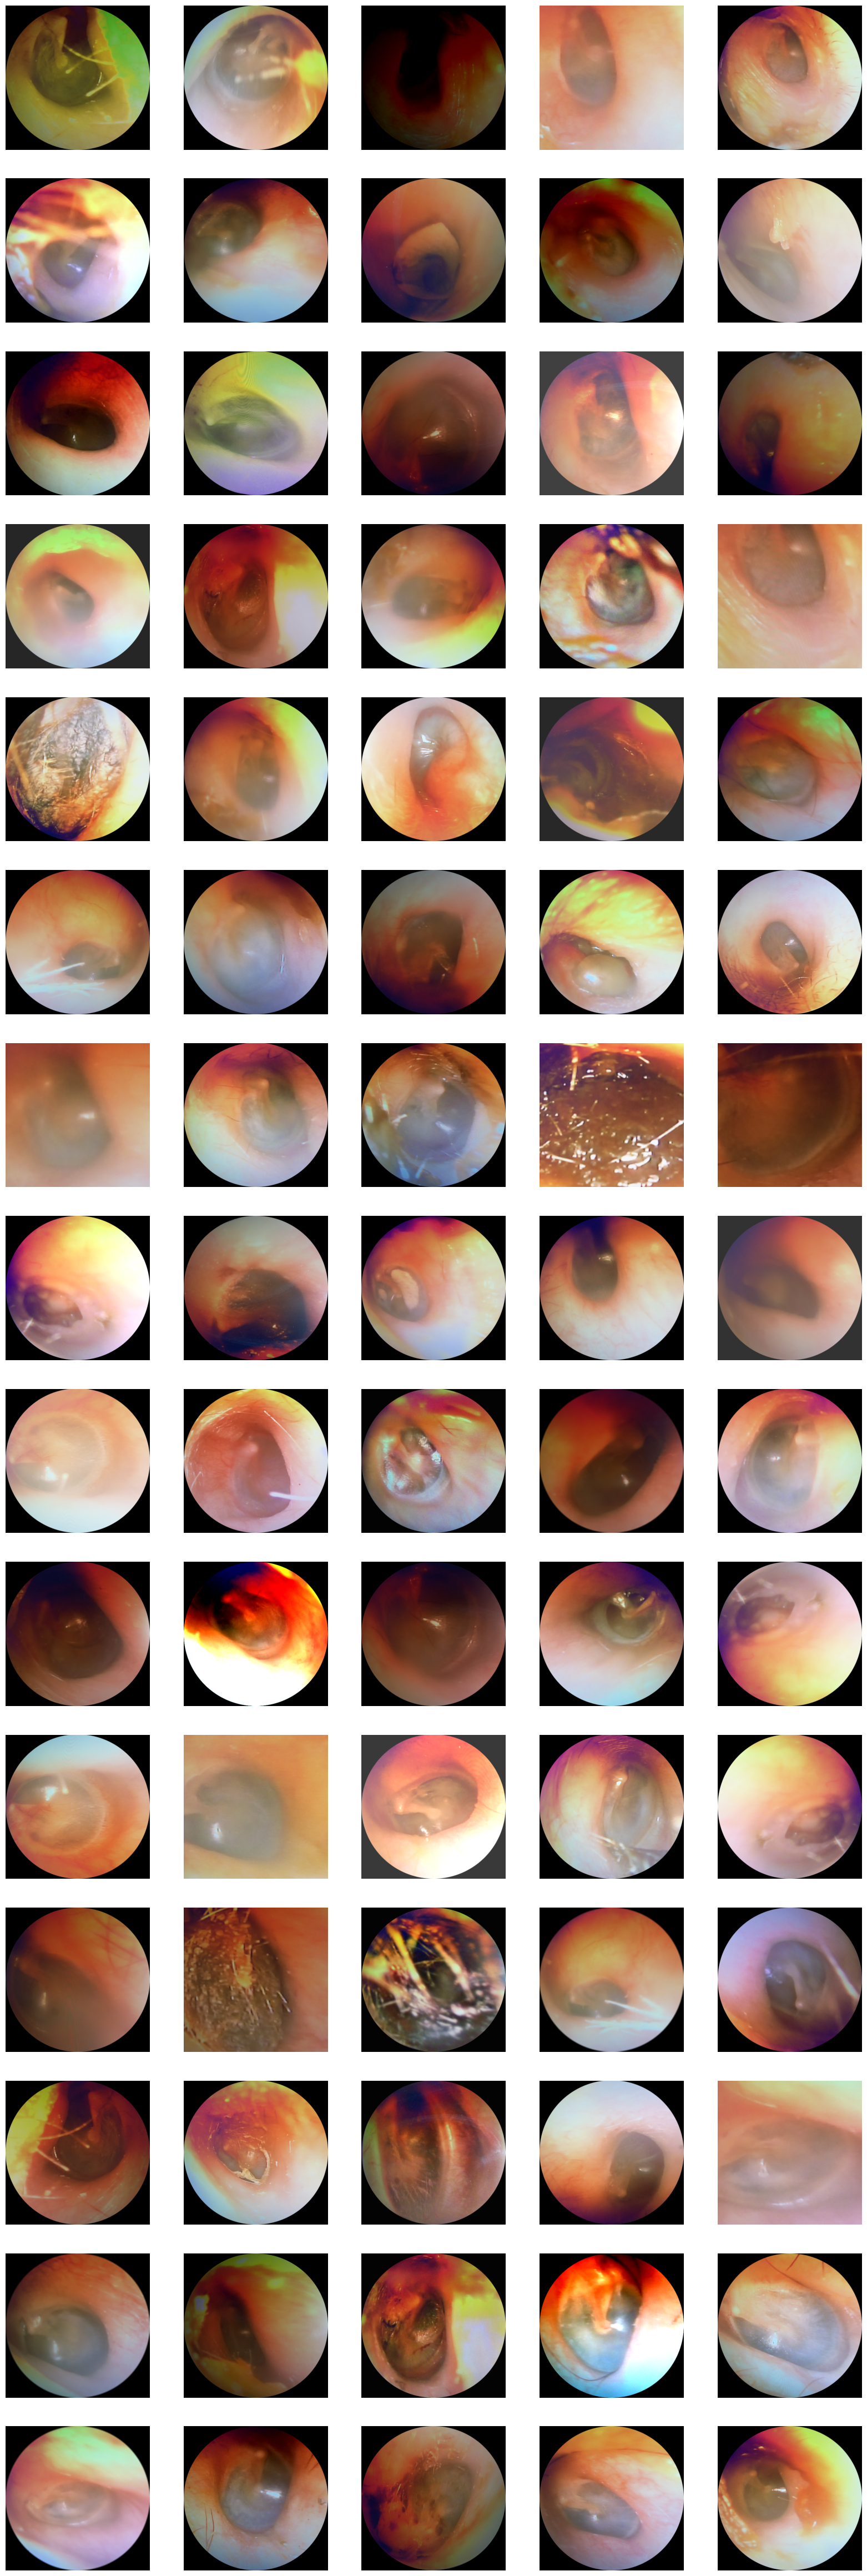

In [36]:
def plot_images(images):
    # 15행 5열로 이미지를 표시
    plt.figure(figsize=(20, 60))
    for i, image in enumerate(images):
        plt.subplot(15, 5, i + 1)  # 15행 5열의 그리드에서 이미지 표시
        plt.imshow(image)
        plt.axis('off')
    plt.show()

# TensorFlow를 사용하여 데이터를 무작위로 섞기
shuffled_indices = tf.random.shuffle(tf.range(len(new_x_train)))
shuffled_x_train = tf.gather(new_x_train, shuffled_indices)

# 1500번째부터 1574번째까지의 이미지 선택 (총 75개 이미지)
final = shuffled_x_train[1500:1575]

# 시각화 실행
plot_images(final)
